Compare the performance between Gerstner's trip model and TripNet performance by calculating the MSE of data used by Gerstner. Plot the predicted data v.s. raw data in stdp, triplet and quadruplet protocol.

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from modelval import data_aug_gp
from sklearn.model_selection import train_test_split
from scipy import stats
from modelval import TripModel, network
from modelval.ArbDataGen import arb_w_gen
from modelval import TripNet, spk_gen
% matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]

# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

len_kernel = 101
len_trip = 151
ker_test = KernelGen(len_kernel=len_kernel, len_trip=len_trip)
ker_test.trip_model_ker(para, data_name='Hippocampus')
ker_test.bias = np.zeros(4).reshape(-1,1)

In [3]:
# Load STDP data with +10 ms and =10 ms time difference
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data1 = data[data['ptl_idx']==1]
data1_net = np.arange(-100, 100, 2)
df1_net = data_aug_gp.STDP_dw_gen(data1_net)

df1_net.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1.0,1.0,0.0,1.0,0.0,60.0,1.0,-100.0,0.0,0.0,-1.32259,0.0,60.0
1,1.0,1.0,0.0,1.0,0.0,60.0,1.0,-98.0,0.0,0.0,-1.32259,0.0,60.0
2,1.0,1.0,0.0,1.0,0.0,60.0,1.0,-96.0,0.0,0.0,-1.32259,0.0,60.0
3,1.0,1.0,0.0,1.0,0.0,60.0,1.0,-94.0,0.0,0.0,-1.32259,0.0,60.0
4,1.0,1.0,0.0,1.0,0.0,60.0,1.0,-92.0,0.0,0.0,-1.32259,0.0,60.0


In [4]:
# Generate spike pairs
ptl_list = [1]
spk_len = int(df1_net['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1]
spk_pairs, _ = arb_w_gen(df=df1_net, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [5]:
# Create the network
ground_truth_init = 0
reg_scale=(1,500,1000)
init_seed=(4,5,6,7)
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [6]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug_gp_mean_noise_alpha1_alpha3_10_long_post_post_diff_bias'

toy_net_trainer = trainer.Trainer(toy_data_net.mse, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

[-0.22614121 -0.27994752  0.95375919] [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


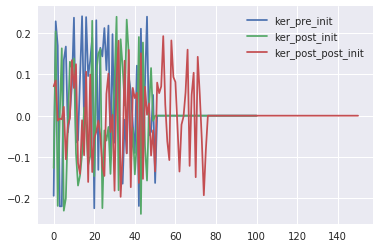

In [7]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_init')
plt.plot(w_post,  label='ker_post_init')
plt.plot(w_post_post,  label='ker_post_post_init')

plt.legend()
print(fc_w, bias)

[array([-1.46580625, -1.47795749,  2.23712564], dtype=float32), array([[ 0.79975992],
       [ 0.18666488],
       [-0.88709372],
       [ 1.0483706 ]], dtype=float32)]


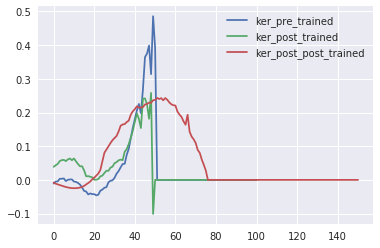

In [8]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1*w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [9]:
# Generate prediction with triplet network
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

_, pred1_net = arb_w_gen(spk_pairs=spk_pairs, spk_len=spk_len, kernel=ker_test, net_type='triplet')
pred1_net = pred1_net/100

In [10]:
pred1_net.shape

(100, 1)

In [11]:
# Generate spike pairs for generating tripmodel prediction
ptl_list = [1]
data1_model = np.linspace(-100, 100, 201)
df1_model = data_aug_gp.STDP_dw_gen(data1_model)
ker_test.reso_kernel=0.5
spk_len = int(df1_model['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1]
spk_pairs, _ = arb_w_gen(df=df1_model, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [12]:
# # Generate equally spaced time distance for feeding the STDP spike generator
# dt_gen = np.linspace(-100, 100, 201)
# ptl_occ_set = 60
# freq_set = 1
# reso_set = 0.5

In [13]:
# pre_spk_ptl1, post_spk_ptl1, target_ptl1 = spk_gen.get_stdp_spikes(dt=dt_gen, rep=1, reso=reso_set, ptl_occ=ptl_occ_set, freq=freq_set, between_train_jitter=0,within_train_jitter=0)

In [14]:
pre_spk_ptl1 = spk_pairs[:,:-2,0]
post_spk_ptl1 = spk_pairs[:,:-2,1]

loci_track_pre = []
loci_track_post = []

# range(pre_spk_ptl1.shape[0])
for i in range(pre_spk_ptl1.shape[0]):
    loci_pre = np.where(pre_spk_ptl1[i,:] > 0)[0]
    loci_post = np.where(post_spk_ptl1[i,:] > 0)[0]
    
    loci_track_pre.append(loci_pre)
    loci_track_post.append(loci_post)

In [15]:
para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 0.5

w_AA_full, S_AA_full, pred1_model = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre, loci_track_post, ifSTDP=1, reso = reso_set, tt_len = 60)

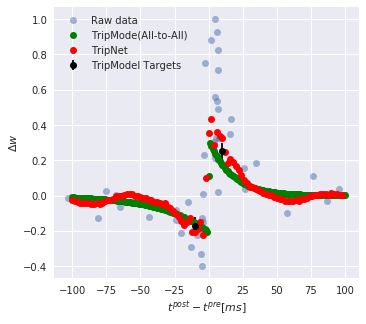

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(data1['dt1'], np.array(data1['dw_mean']/100), 'o',alpha=0.5, label='Raw data')
plt.errorbar(x=np.array([-10,10]), y=np.array([-0.17,0.25]), yerr=np.array([0.05,0.05]),color='k', fmt='o', label='TripModel Targets')
plt.plot(data1_model,pred1_model,'go',label='TripMode(All-to-All)')
plt.plot(data1_net, pred1_net,'ro' , label='TripNet')
plt.xlabel('$t^{post} - t^{pre}[ms]$')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

In [17]:
# Obtain the mse
x=np.array([-10,10])
x_model = np.zeros(len(x), dtype=int)
x_net = np.zeros(len(x), dtype=int)
pred1_model_x = []
pred1_net_x = []

for i in range(len(x)):
    x_model[i] = np.where((data1_model - int(x[i]))==np.min(np.abs(data1_model - int(x[i]))))[0][0]
    x_net[i] = np.where((data1_net - int(x[i]))==np.min(np.abs(data1_net - int(x[i]))))[0][0]
    pred1_model_x.append(pred1_model[x_model[i]])
    pred1_net_x.append(pred1_net[x_net[i]])
    
pred1_model_x = np.hstack(pred1_model_x)
pred1_net_x = np.hstack(pred1_net_x)

def err(target, pred, sigma):
    err = np.sum(np.square((target-pred)/sigma))
    return err

err_model = err(np.array([-0.17, 0.25]),pred1_model_x, np.array([0.05,0.05]))
err_net = err(np.array([-0.17, 0.25]), pred1_net_x,np.array([0.05,0.05]))

print(err_model, err_net)

2.30624346113 2.99477331557
